# Aufgabe 3: Aufgabe 3: Cross Validation und Grid Search

In dieser Aufgabe geht es um Hyperparameter-Optimierung mittels Grid-Search (deutsch: Gittersuche). Dabei handelt es sich um eine Brute-Force-Suche, die auf einen angegebenen Teil des Hyperparameterraums angewandt wird. Sie wird dabei von einer Performance-Metrik geleitet.

Die Gittersuche soll in diesem Notebook auf zwei verschiedene Klassifikationsaufgaben angewandt werden:

- Iris Flower Dataset
- evtl breast cancer?

Anschließend soll für beide Aufgaben jeweils eine Kurve mit der Suchzeit in Abhängigkeit von der Anzahl an CPU- Kernen geplottet werden. Außerdem soll die Zielmetrik in Abhängigkeit von einem ausgewählten Hyperparameter geplottet werden.

## Importiere Bibliotheken

In [31]:
# Import Libraries
import time
import multiprocessing

import pandas as pd

from sklearn import svm
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

## Iris Flower Dataset

In [6]:
# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
iris = pd.read_csv(url, names=names)

Iteriere durch die Anzahl der vorhandenen Prozessorkerne und starte jeweils ein GridSearch. Miss jeweils die notwendige Zeit für das Fitting und speicher Ergebnis in eine Liste.

In [34]:
# Split-out validation dataset
array = dataset.values
X = array[:,0:4]
Y = array[:,4]
test_size = 0.20
seed = 7
X_train, X_validation, y_train, y_validation = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)

In [35]:
def grid_search_with_cores(classifier, parameters, X_train, y_train, core_range=None):
    
    if core_range is None:
        core_range = list(range(1, multiprocessing.cpu_count()+1))
        
    times = []
    cores = []

    for n in core_range:
        # GridSearch starten
        grid_search = GridSearchCV(classifier, parameters, n_jobs=n)

        # Startzeit
        start = time.time()

        # Modell trainieren
        grid_search.fit(X_train, y_train)

        # Endzeit
        end = time.time()

        cores.append(n)
        times.append(end - start)

        results = pd.DataFrame(data=grid_search.cv_results_)

    # Ergebnissliste in DataFrame umwandeln
    return pd.DataFrame(data={'times': times, 'n_cores': cores})

In [37]:
# Hyper-Parameter Space
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

# SVM als Klassifikator
svc = svm.SVC()

df = grid_search_with_cores(svc, parameters, X_train, y_train)

/smartdata/uiuqb/.conda/envs/aufgabe1/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/smartdata/uiuqb/.conda/envs/aufgabe1/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/smartdata/uiuqb/.conda/envs/aufgabe1/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **w

/smartdata/uiuqb/.conda/envs/aufgabe1/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/smartdata/uiuqb/.conda/envs/aufgabe1/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/smartdata/uiuqb/.conda/envs/aufgabe1/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **w

/smartdata/uiuqb/.conda/envs/aufgabe1/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/smartdata/uiuqb/.conda/envs/aufgabe1/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/smartdata/uiuqb/.conda/envs/aufgabe1/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **w

/smartdata/uiuqb/.conda/envs/aufgabe1/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/smartdata/uiuqb/.conda/envs/aufgabe1/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/smartdata/uiuqb/.conda/envs/aufgabe1/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **w

## Breast Cancer

In [9]:
bc = datasets.load_breast_cancer()
print(bc.data.shape)
print(bc.target.shape)

(569, 30)
(569,)


Iteriere durch die Anzahl der vorhandenen Prozessorkerne und starte jeweils ein GridSearch. Miss jeweils die notwendige Zeit für das Fitting und speicher Ergebnis in eine Liste.

In [14]:
multiprocessing.cpu_count()

16

In [18]:
# Variablen
times = []
cores = []

# Zu testende Hyperparameter
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

# Anzahl der Prozessorkerne
n_cores = multiprocessing.cpu_count()

for n in range(1, n_cores+1):

    # SVM als Klassifikator
    svc = svm.SVC()

    # GridSearch starten
    clf = GridSearchCV(svc, parameters, n_jobs=n)
    
    # Startzeit
    start = time.time()
    
    # Modell trainieren
    clf.fit(bc.data, bc.target)
    
    # Endzeit
    end = time.time()
    
    cores.append(n)
    times.append(end - start)

    results = pd.DataFrame(data=clf.cv_results_)

# Ergebnissliste in DataFrame umwandeln
d = {'times': times, 'n_cores': cores}
df = pd.DataFrame(data=d)

/home/dominik/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/dominik/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/dominik/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/dominik/anaconda3/lib/py

In [27]:
# Hyper-Parameter Space
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

# SVM als Klassifikator
svc = svm.SVC()

df = grid_search_with_cores(svc, parameters, X_train=bc.data, y_train=bc.target, core_range=[1, 2])

/smartdata/uiuqb/.conda/envs/aufgabe1/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/smartdata/uiuqb/.conda/envs/aufgabe1/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/smartdata/uiuqb/.conda/envs/aufgabe1/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **w

In [39]:
df

,n_cores,times
0,1,0.030011
1,2,0.296788
2,3,0.308103
3,4,0.322670
4,5,0.337213
5,6,0.348500
6,7,0.359329
7,8,0.373659
8,9,0.390230
9,10,0.408290


Plotte die benötigte Zeit in Abhängigkeit zur Anzahl der Kerne

[Text(0,0.5,'Time in seconds'), Text(0.5,0,'#Cores')]

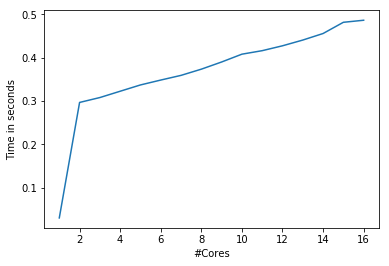

In [38]:
plot = df.plot(x='n_cores', y='times', legend=False)
plot.set(xlabel="#Cores", ylabel="Time in seconds")

Plotte die Ergebnisse der letzten Iteration, also mit allen Kernels

In [7]:
results

NameError: name 'results' is not defined